In [6]:
#deklarasi direktori file yang digunakan
train_path = 'data/chest_xray/train'
valid_path = 'data/chest_xray/val'
test_path = 'data/chest_xray/test'
import tensorflow as tf

#cek gpu
print ("Num GPU Avaialbale: ", len(tf.config.experimental.list_physical_devices('GPU'))) 

Num GPU Avaialbale:  1


In [7]:
#deklarasi untuk membaca dan mengubah size citra dengan preoprocessing_function vgg16 menciptakan citra dengan bentuk 16,224,224,3
#dengan batch size 16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['PNEUMONIA', 'NORMAL'], batch_size=16)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['PNEUMONIA', 'NORMAL'], batch_size=16)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes=['PNEUMONIA', 'NORMAL'], batch_size=16, shuffle=False)

Found 2400 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [8]:
# contoh ukuran citra yang terbentuk
imgs, labels = next(train_batches)
print(imgs.shape)


(16, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


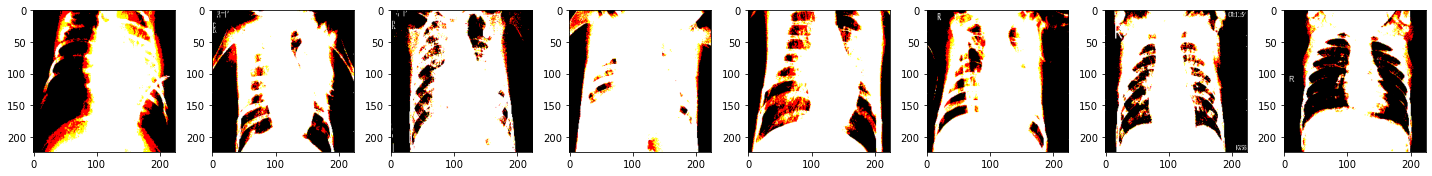

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [12]:
#mendefinsikan plotImages untuk menampilkan citra yang terbentuk dari preoprocessing_function di imagedatagenerator
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 8, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img,cmap='gray')
        ax.axis('on')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
plotImages(imgs)
print(labels)

In [13]:
#arsitektur Densenet-169

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

def densenet(input_shape, n_classes, filters = 32):
    
    #definisi bn_rl_conv untuk denseblock
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    #definsikan denseblock yang terdiri bn (batch normalization) rl (reLU activation) dan 3x3 conv(convolutional)
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
    #mendefinisikan transition layer terdiri dr bn 1x1 conv dan average pooling 
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

    #input gambar dan deklrasi stride, padding untuk conv2d dan maxpool2d pada awal sebelum masuk ke denseblock dan transistion layer
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    #tahapan seetelah maxpool2d dan masuk ke denseblock dan transition layer dengan jumlah layer denseblock 6,12,32,32
    for repetition in [6,12,32,32]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
     
    
    #classification layer global average pooling dan fullyconnected layer activation sigmoid (karena hanya dua kelas)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'sigmoid')(x)
    
    #deklarasi nama model dari arsitektur cnn = model
    model = Model(input, output)
    return model

#input ukuran citra dan class
input_shape = 224, 224, 3
n_classes = 2
model = densenet(input_shape,n_classes)

#model arstiktur cnn disimpan dgn nama beikut
model.save('densenet-169-2class.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: densenet-169-2class.model\assets


In [14]:
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
#deklarasi nama folder yang akan disimpan untuk menampilkan grafik loss accuracy vs epoch pada tensorboard
NAME = "{}-len train batches-{}-len valid batches{}-day7".format(len(train_batches), len(valid_batches), int(time.time()))

#model compile dengan adam optimizer dan loss function categorical crossentropy 
model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

#membuat folder pada path berikut 
tensorboard = TensorBoard(log_dir="D:\\newday\{}".format(NAME))

In [15]:
#earlystopping agar saat fitting akan langsung berhenti ketika model tidak dapat ditingkat (menghindari overfitting dengan jumlah epoch yang besar)
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction, tensorboard ]

In [16]:
#flowchart aristektur densenet169
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [17]:
#fitting model dengan epoch di set 100 
print(NAME)
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=100,
          verbose=1,callbacks=callbacks_list)

150-len train batches-15-len valid batches1625988651-day7
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 150 steps, validate for 15 steps
Epoch 1/100
150/150 [==============================] - 132s 879ms/step - loss: 0.5943 - accuracy: 0.7321 - val_loss: 0.6414 - val_accuracy: 0.8000
Epoch 2/100
150/150 [==============================] - 82s 548ms/step - loss: 0.4297 - accuracy: 0.8712 - val_loss: 0.4385 - val_accuracy: 0.8667
Epoch 3/100
150/150 [==============================] - 82s 549ms/step - loss: 0.3453 - accuracy: 0.8904 - val_loss: 0.3415 - val_accuracy: 0.8667
Epoch 4/100
150/150 [==============================] - 83s 552ms/step - loss: 0.3043 - accuracy: 0.9013 - val_loss: 0.3180 - val_accuracy: 0.8708
Epoch 5/100
150/150 [==============================] - 83s 554ms/step - loss: 0.2818 - accuracy: 0.9075 - val_loss: 0.2989 - val_accuracy: 0.8833
Epoch 6/100
150/150 [==============================] - 83s 554ms/step - loss: 0.2656 - accuracy: 0.9104 - val_loss: 0.

In [18]:
#test akurasi
test_accu = model.evaluate(test_batches)
print('The testing accuracy is :',test_accu[1]*100, '%')

  ...
    to  
  ['...']
30/30 [==============================] - 12s 416ms/step - loss: 0.5609 - accuracy: 0.8292
The testing accuracy is : 82.91666507720947 %


In [19]:
#model prediksi
preds = model.predict(test_batches,verbose=1)

30/30 [==============================] - 9s 309ms/step


In [20]:
#hasil ekstraksi fitur
preds

array([[7.87979644e-03, 1.42967757e-02],
       [1.41776502e-01, 8.20782559e-04],
       [2.66589433e-01, 2.67248834e-04],
       [7.46913373e-01, 1.31637016e-05],
       [2.21408069e-01, 6.34235446e-04],
       [4.27233994e-01, 2.30671183e-04],
       [2.02085003e-01, 6.10452087e-04],
       [8.61080829e-03, 2.98809586e-03],
       [2.45369270e-01, 6.21251587e-04],
       [1.22322544e-01, 1.37884368e-03],
       [5.30745834e-02, 1.40647090e-03],
       [3.58707607e-02, 4.52853448e-04],
       [3.81007820e-01, 2.23966010e-04],
       [8.67209807e-02, 1.54550083e-03],
       [1.43258750e-01, 2.27737793e-04],
       [2.49216259e-02, 3.47772148e-03],
       [5.04474759e-01, 6.98533113e-05],
       [3.04373890e-01, 1.74973742e-04],
       [3.22156787e-01, 2.70906283e-04],
       [2.37229049e-01, 5.43446629e-04],
       [3.39138322e-03, 9.03817825e-03],
       [1.26573950e-01, 5.88215131e-04],
       [6.75672516e-02, 1.59175100e-03],
       [4.62170243e-01, 1.21309262e-04],
       [1.087173

In [25]:
#epoch yang saat fitting hanya mencapai 38 dikarenakan earlystopping 

In [22]:
#klasifikasi dengan nearest neighbour

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:

import numpy as np
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(preds, axis=-1))

Confusion matrix, without normalization
[[226  14]
 [ 68 172]]


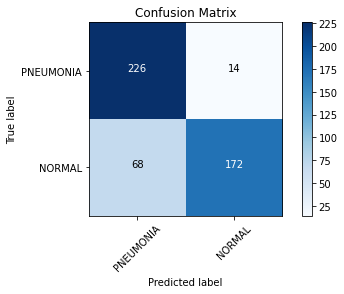

In [24]:
#confusion matrix
import itertools
cm_plot_labels = ['PNEUMONIA','NORMAL']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')